In [ ]:
!pip install missingno

In [168]:
import os
import pandas as pd
import numpy as np
from datetime import timedelta

Data Cleaning Functions:
    1. Normalize date to nearest 15T min increment
    2. Fill empty rows with DataTimeStamps where data is missing
    3. Data quality check
    3. Visualize missing data 
    4. Decide on data imputation

In [169]:
# Function to normalize time to the nearest 15-minute increment
def round_time_to_15min(dt):
    dt += timedelta(minutes=7.5)
    dt -= timedelta(minutes=dt.minute % 15, seconds=dt.second)
    return dt

In [162]:
# Function to fill gaps in data with empty rows

def fill_gaps(df):
    year = df['DateTimeStamp'].dt.year.iloc[0]          # Get the year from the DateTimeStamp column
    start_time = pd.Timestamp(year, 1, 1)              # Set the start time to the beginning of the year
    end_time = pd.Timestamp(year, 12, 31, 23, 59, 59)     # Set the end time to the end of the year
    expected_times = pd.date_range(start=start_time, end=end_time, freq='15T')  # Generate expected times within the year
    
    # Find missing times within the year
    missing_times_within_year = expected_times[~expected_times.isin(df['DateTimeStamp'])]
    
    # Create missing data DataFrame
    missing_data = pd.DataFrame({
        'DateTimeStamp': missing_times_within_year,
        'Occupancy': np.nan,
        'Volume': np.nan,
        'Speed': np.nan
    })
    
    filled_df = pd.concat([df, missing_data]).sort_values(by='DateTimeStamp')    # Concatenate missing_data with original DataFrame
    
    return filled_df

In [ ]:
# Main script to clean the sensor data

input_directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/2. transformed sensor files/2019'
output_directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2019'

# Read and process each CSV file
for filename in os.listdir(input_directory):
    if filename.endswith(".csv"):
        input_filepath = os.path.join(input_directory, filename)
        df = pd.read_csv(input_filepath, parse_dates=['DateTimeStamp'])

        # Normalize time to the nearest 15-minute increment
        df['DateTimeStamp'] = df['DateTimeStamp'].apply(round_time_to_15min)

        # Fill gaps in data with empty rows
        df = fill_gaps(df)

        # Save the processed data to a new CSV file
        output_filename = os.path.splitext(filename)[0] + '_processed.csv'
        output_filepath = os.path.join(output_directory, output_filename)
        df.to_csv(output_filepath, index=False)

        print(f"Processed file: {output_filepath}")

-------------------

In [ ]:
# Data Quality Check
# Check if the row count of each CSV file is equal to 35040 - quick check

def check_csv_row_count(directory):
    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.csv')]
    
    for file_path in file_paths:
        df = pd.read_csv(file_path)
        row_count = len(df)
        
        # Check if the row count is not equal to 35040
        if row_count != 35040:
            print(f"{file_path}: {row_count} rows")
          

# Set directory path
check_csv_row_count('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2019')

In [176]:
# Data Quality Check
# Check for duplicates in column 1 (DateTimeStamp)

def check_duplicates_in_column1(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    
    for file_name in csv_files:
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        
        # Calculate row count
        row_count = len(df)
        
        # Check for duplicates in the first column
        duplicates = df[df.duplicated(subset=[df.columns[0]], keep=False)]
        
        if not duplicates.empty:
            print(f"Duplicates found in {file_name} (Total Rows: {row_count}):")
            print(duplicates)
        else:
            print(f"No duplicates found in {file_name} (Total Rows: {row_count})")

# Set directory path
check_duplicates_in_column1('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2019')


No duplicates found in 10.1.267_processed.csv (Total Rows: 35040)
Duplicates found in 10.2.268_processed.csv (Total Rows: 35045):
             DateTimeStamp  Occupancy  Volume  Speed
29381  2019-11-03 01:15:00       10.0   547.0  67.00
29382  2019-11-03 01:15:00        5.0   361.0  67.25
29383  2019-11-03 01:30:00       12.0   616.0  66.75
29384  2019-11-03 01:30:00        5.0   390.0  68.00
29385  2019-11-03 01:45:00        9.0   488.0  66.75
29386  2019-11-03 01:45:00        4.0   311.0  67.25
29387  2019-11-03 02:00:00        9.0   450.0  66.00
29388  2019-11-03 02:00:00        4.0   283.0  68.00
No duplicates found in 101.1.35_processed.csv (Total Rows: 35040)
No duplicates found in 101.1.755_processed.csv (Total Rows: 35041)
No duplicates found in 102.1.769_processed.csv (Total Rows: 35041)
Duplicates found in 102.2.37_processed.csv (Total Rows: 35044):
             DateTimeStamp  Occupancy  Volume  Speed
29381  2019-11-03 01:15:00       11.0   540.0  65.75
29382  2019-11-03 01:15

In [ ]:
# Data Quality Check
# Aggregate duplicates by taking the mean of the values and rounding to the nearest integer for Occupancy and Volume and to 2 decimal places for Speed

def check_and_handle_duplicates(directory):
    csv_files = [file for file in os.listdir(directory) if file.endswith('.csv')]
    for file_name in csv_files:
        file_path = os.path.join(directory, file_name)
        df = pd.read_csv(file_path)
        duplicate_timestamps = df[df.duplicated(subset=['DateTimeStamp'], keep=False)]
        
        # Handle duplicates by aggregating values
        if not duplicate_timestamps.empty:
            # Aggregate duplicates by taking the mean of numeric columns
            aggregated_df = duplicate_timestamps.groupby('DateTimeStamp').mean().reset_index()
            # Round 'Occupancy' and 'Volume' columns to nearest integer
            aggregated_df['Occupancy'] = aggregated_df['Occupancy'].round().astype(int)
            aggregated_df['Volume'] = aggregated_df['Volume'].round().astype(int)
            df.drop_duplicates(subset=['DateTimeStamp'], keep=False, inplace=True)
            df = pd.concat([df, aggregated_df], ignore_index=True)
            df.to_csv(file_path, index=False)

            print(f"Duplicates handled in {file_name}")
        else:
            print(f"No duplicates found in {file_name}")

# Set directory path
check_and_handle_duplicates('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018')

In [102]:
df = pd.read_csv('../Chloe - Reduced Detector Data - all_combined.csv', header=None)
result = df[df[1].str.contains("I-15 NB", na=False)][0].tolist()

result = [value.replace('_', '.') for value in result]

total_elements = len(result)
print(f"Total elements: {total_elements}")

directory = 'C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018'

speed_data = pd.DataFrame()

# Iterate over each name in the result list
for name in result:
    # Add '_processed' suffix to the name
    processed_name = f"{name}_processed"
    
    if os.path.exists(os.path.join(directory, f'{processed_name}.csv')):
        # Read the CSV file into a DataFrame
        file_df = pd.read_csv(os.path.join(directory, f'{processed_name}.csv'))
        
        # Extract the 'Speed' column
        speed_column = file_df['Speed']
        
        # Extract the file name without the '_processed' part
        file_name = processed_name.replace('_processed', '')
        
        # Rename the column with the file name
        speed_column = speed_column.rename(file_name)
        
        # Convert the speed column to a DataFrame with a single column
        speed_column = pd.DataFrame(speed_column)
        
        # Concatenate the speed column to the speed_data DataFrame
        speed_data = pd.concat([speed_data, speed_column], axis=1)
    else:
        print(f"File not found: {processed_name}.csv")

# Print the concatenated DataFrame
print(speed_data)

Total elements: 180
File not found: 127.1.531_processed.csv
File not found: 160.1.241_processed.csv
File not found: 167.1.531_processed.csv
File not found: 23.1.8_processed.csv
File not found: 23.2.8_processed.csv
File not found: 30.2.8_processed.csv
File not found: 39.1.8_processed.csv
File not found: 437.1.101_processed.csv
File not found: 524.3.8_processed.csv
File not found: 53.2.15_processed.csv
File not found: 536.1.100_processed.csv
File not found: 538.1.101_processed.csv
File not found: 544.1.99_processed.csv
File not found: 545.1.99_processed.csv
File not found: 698.1.539_processed.csv
File not found: 403.3.448_processed.csv
File not found: 160.1.241 _processed.csv
File not found: 161.2.241_processed.csv
File not found: 34.2.90_processed.csv
File not found: 356.3.313_processed.csv
File not found: 437.1.328_processed.csv
File not found: 437.2.327_processed.csv
File not found: 441.2.337_processed.csv
File not found: 442.3.339_processed.csv
File not found: 446.2.78_processed.csv


In [142]:
dt = pd.read_csv('C:/Users/Tarek Zahid/Desktop/xie/Sensor Files/3. cleaned sensor files/2018/72.2.28_processed.csv', parse_dates=['DateTimeStamp'])
dt=dt.iloc[:, 0]
dt


0       2018-01-01 00:00:00
1       2018-01-01 00:15:00
2       2018-01-01 00:30:00
3       2018-01-01 00:45:00
4       2018-01-01 01:00:00
                ...        
35035   2018-12-31 23:30:00
35036   2018-12-31 23:45:00
35037   2018-11-04 01:15:00
35038   2018-11-04 01:30:00
35039   2018-11-04 01:45:00
Name: DateTimeStamp, Length: 35040, dtype: datetime64[ns]

In [144]:
speed_data.reset_index(drop=True, inplace=True)
speed_data

,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,398.3.411,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,62.500000,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,53.500000,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
3,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,51.500000,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
4,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,59.500000,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,61.333333,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
35036,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,61.000000,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
35037,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,41.666667,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00
35038,NaN,57.50,54.0,NaN,NaN,0.0,0.0,63.75,0.0,38.833333,...,NaN,64.166667,61.75,63.666667,NaN,NaN,NaN,79.25,70.75,73.25


In [145]:
speed_data_2=speed_data
speed_data_2 = pd.concat([dt, speed_data_2], axis=1)
#speed_data_2 = speed_data_2.iloc[:, 1:]

In [146]:
speed_data_2

,DateTimeStamp,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
0,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 00:15:00,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2,2018-01-01 00:30:00,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
3,2018-01-01 00:45:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
4,2018-01-01 01:00:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35035,2018-12-31 23:30:00,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
35036,2018-12-31 23:45:00,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
35037,2018-11-04 01:15:00,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00
35038,2018-11-04 01:30:00,NaN,57.50,54.0,NaN,NaN,0.0,0.0,63.75,0.0,...,NaN,64.166667,61.75,63.666667,NaN,NaN,NaN,79.25,70.75,73.25


<Axes: >

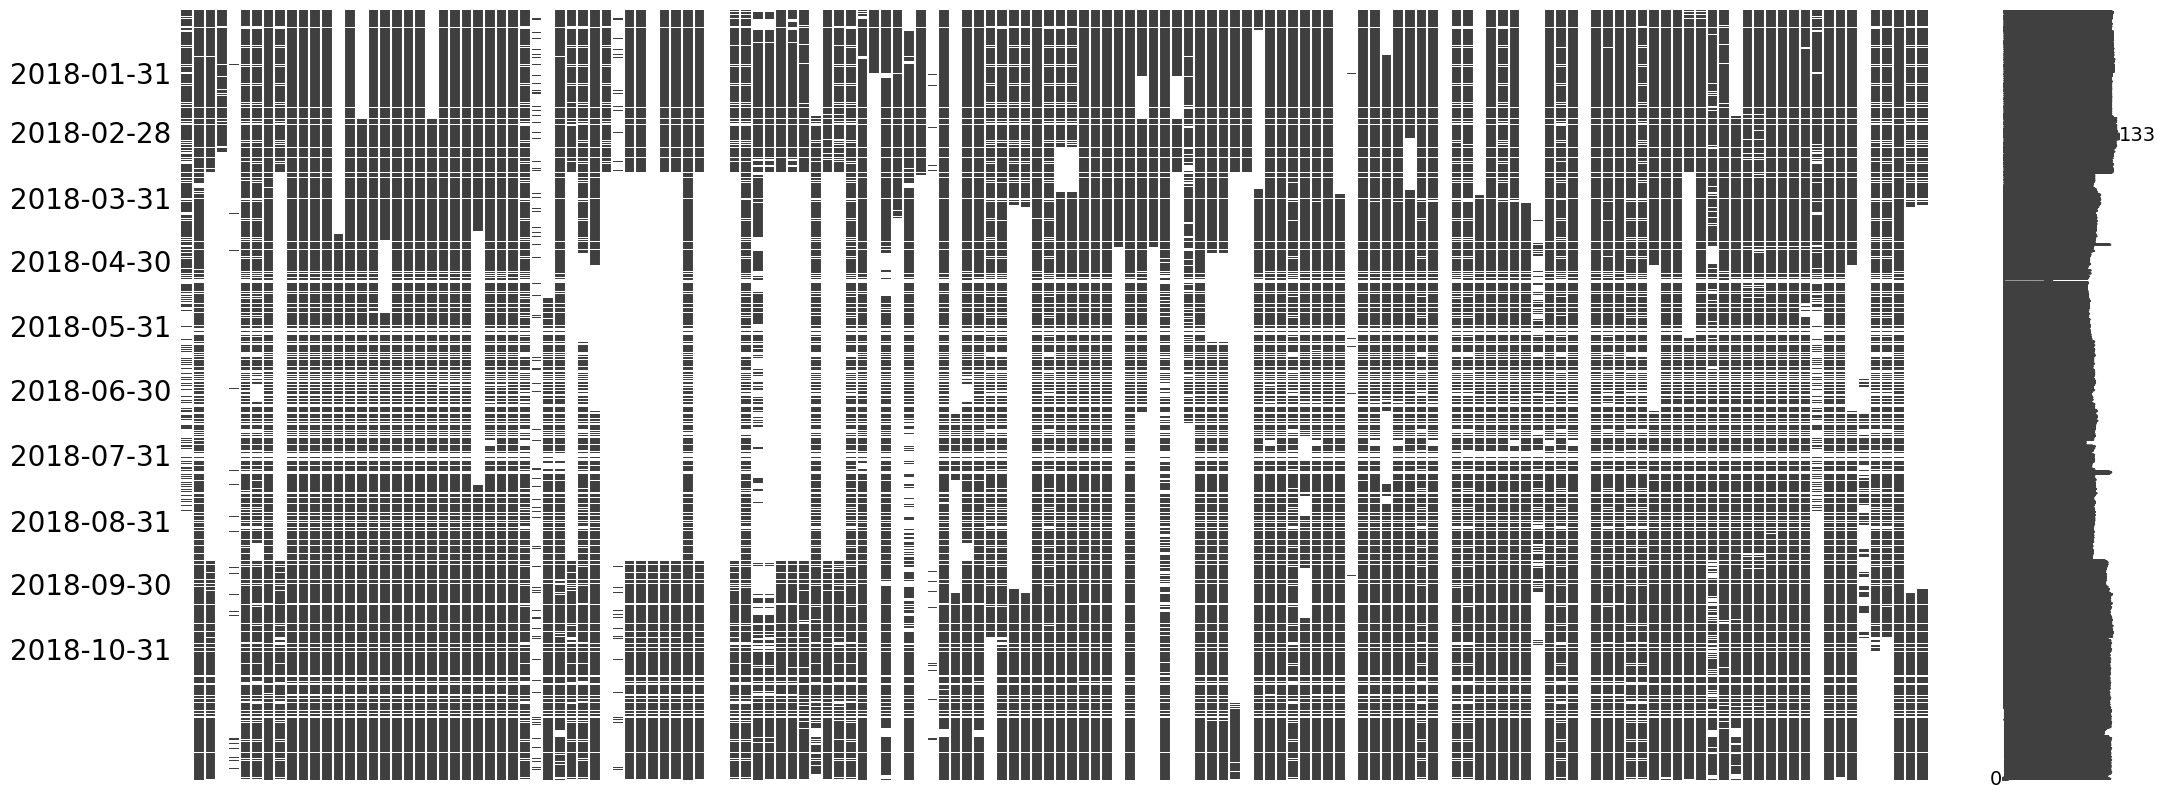

In [157]:
#speed_data_2['DateTimeStamp'] = pd.to_datetime(speed_data_2['DateTimeStamp'])

#speed_data_2.set_index('DateTimeStamp', inplace=True)

speed_data_2.index = pd.to_datetime(speed_data_2.index)
msno.matrix(speed_data_2, freq='M')

GridSpec(6, 6)

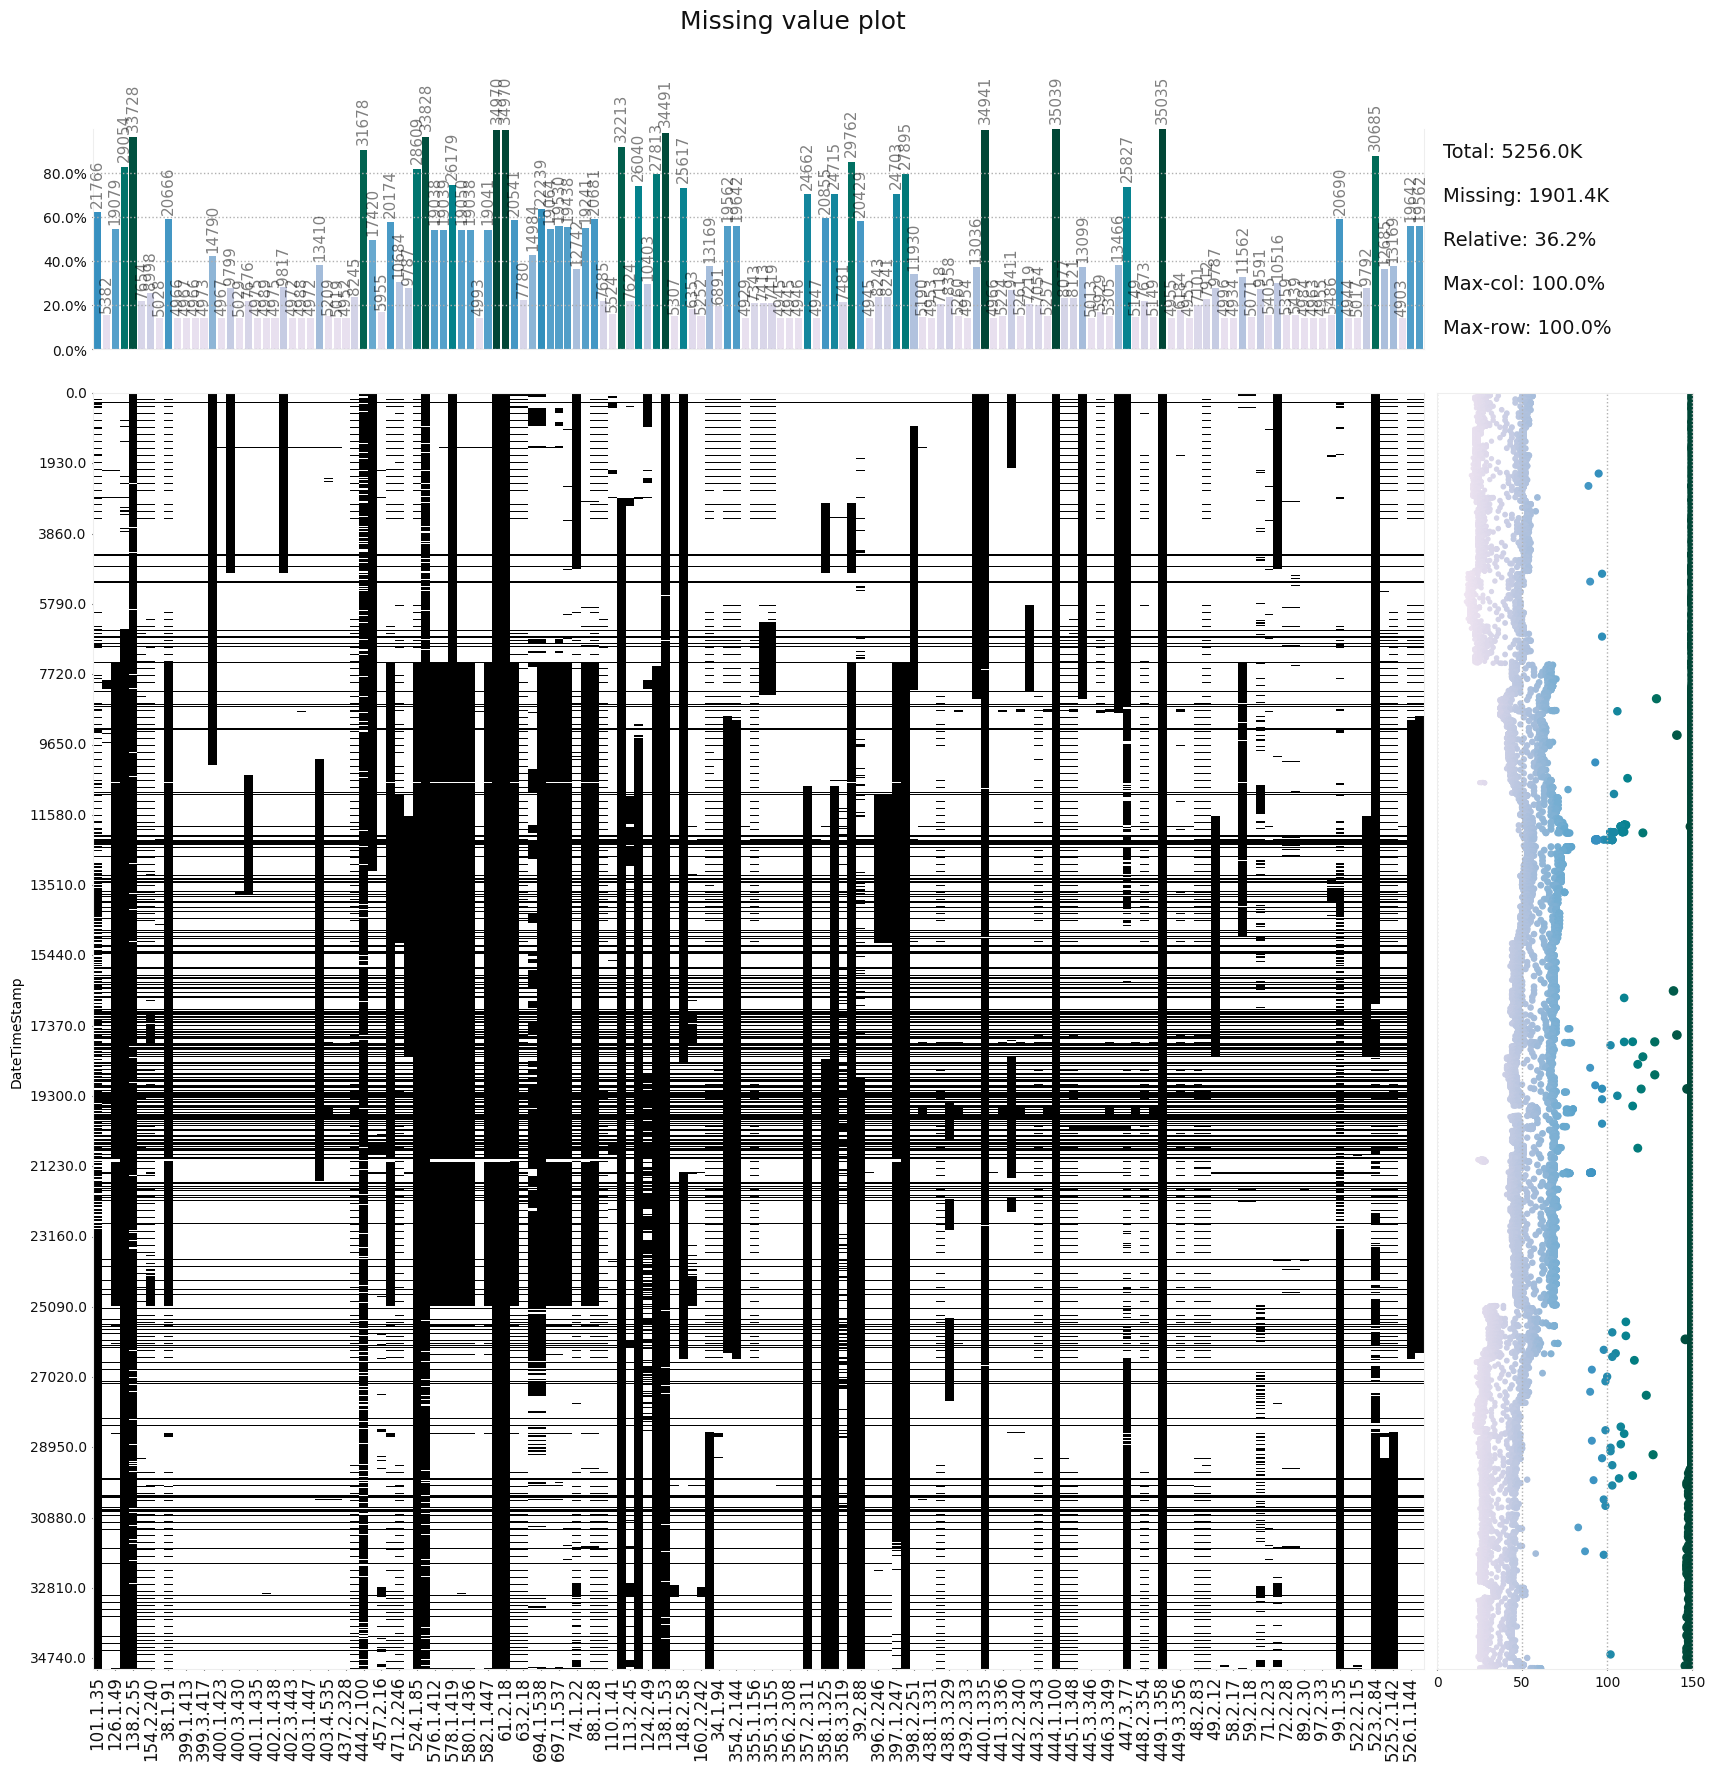

In [159]:
speed_data_2.index = pd.to_datetime(speed_data_2.index)

klib.missingval_plot(speed_data_2)

In [180]:
speed_data_2

,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,398.3.411,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
DateTimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:15:00,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,62.500000,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2018-01-01 00:30:00,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,53.500000,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
2018-01-01 00:45:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,51.500000,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
2018-01-01 01:00:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,59.500000,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:30:00,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,61.333333,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
2018-12-31 23:45:00,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,61.000000,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
2018-11-04 01:15:00,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,41.666667,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00


In [181]:
# drop column with more than 30% missing values
df=speed_data_2

missing_percentage = df.isna().mean() * 100

columns_to_drop = missing_percentage[missing_percentage > 30].index

# Drop the columns from the DataFrame
df_70 = df.drop(columns=columns_to_drop)

# Now df contains columns with less than or equal to 30% missing values


In [185]:
df_70

,125.2.49,141.2.55,154.2.240,167.2.210,398.3.411,399.1.413,399.2.414,399.3.417,400.1.423,400.2.425,...,72.2.28,89.1.28,89.2.30,97.1.33,97.2.33,97.3.38,522.1.17,522.2.15,523.1.12,525.3.145
DateTimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:15:00,55.50,0.0,0.0,64.00,62.500000,0.000,71.000,66.000,28.000000,NaN,...,62.000000,54.000000,61.50,65.666667,59.333333,61.500000,44.000000,56.00,59.500000,82.00
2018-01-01 00:30:00,55.00,0.0,0.0,62.50,53.500000,0.000,67.000,66.000,28.000000,NaN,...,67.666667,57.333333,65.25,68.333333,60.166667,61.666667,28.333333,55.00,59.000000,81.50
2018-01-01 00:45:00,54.00,0.0,0.0,61.50,51.500000,0.000,71.000,67.500,28.000000,NaN,...,69.333333,59.333333,66.00,69.000000,62.333333,63.166667,11.333333,55.00,59.000000,84.50
2018-01-01 01:00:00,54.00,0.0,0.0,63.00,59.500000,0.000,70.000,70.000,28.000000,NaN,...,69.333333,57.000000,66.00,68.333333,60.333333,63.000000,26.500000,55.00,58.000000,84.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:30:00,61.00,0.0,0.0,63.00,61.333333,71.000,65.250,73.500,75.000000,58.500,...,67.666667,54.000000,63.00,65.833333,58.833333,62.000000,NaN,NaN,39.000000,80.50
2018-12-31 23:45:00,61.50,0.0,0.0,64.00,61.000000,73.750,68.250,75.500,76.333333,62.500,...,67.333333,54.666667,64.00,66.000000,47.833333,61.166667,NaN,NaN,37.666667,80.00
2018-11-04 01:15:00,57.00,0.0,0.0,63.25,41.666667,68.875,66.625,67.375,72.833333,57.875,...,72.333333,61.166667,68.75,69.900000,50.750000,59.083333,61.833333,60.50,64.833333,76.00


In [193]:
import pandas as pd

# Assuming your DataFrame is named df_70
# Initialize variables to store results
max_consecutive_missing_all = 0
min_consecutive_missing_all = float('inf')
max_consecutive_missing_per_column = {}
min_consecutive_missing_per_column = {}

# Iterate through each column
for column in df_70.columns:
    consecutive_missing = 0
    max_consecutive_missing = 0
    min_consecutive_missing = float('inf')

    # Iterate through each row
    for index, value in df_70[column].isna().items():
        if value:  # If value is missing
            consecutive_missing += 1
            max_consecutive_missing = max(max_consecutive_missing, consecutive_missing)
        else:  # If value is not missing
            if consecutive_missing != 0:  # Skip counting if consecutive missing rows is zero
                min_consecutive_missing = min(min_consecutive_missing, consecutive_missing)
            consecutive_missing = 0

    # Update overall maximum and minimum consecutive missing rows
    max_consecutive_missing_all = max(max_consecutive_missing_all, max_consecutive_missing)
    min_consecutive_missing_all = min(min_consecutive_missing_all, min_consecutive_missing)

    # Store results for each column
    max_consecutive_missing_per_column[column] = max_consecutive_missing
    min_consecutive_missing_per_column[column] = min_consecutive_missing

# Print the results
print("Maximum consecutive missing rows in one column:", max(max_consecutive_missing_per_column.values()))
print("Minimum consecutive missing rows in one column (excluding zero):", min(min_consecutive_missing_per_column.values()))
print("Maximum consecutive missing rows in all columns:", max_consecutive_missing_all)
print("Minimum consecutive missing rows in all columns (excluding zero):", min_consecutive_missing_all)



Maximum consecutive missing rows in one column: 6229
Minimum consecutive missing rows in one column (excluding zero): 1
Maximum consecutive missing rows in all columns: 6229
Minimum consecutive missing rows in all columns (excluding zero): 1


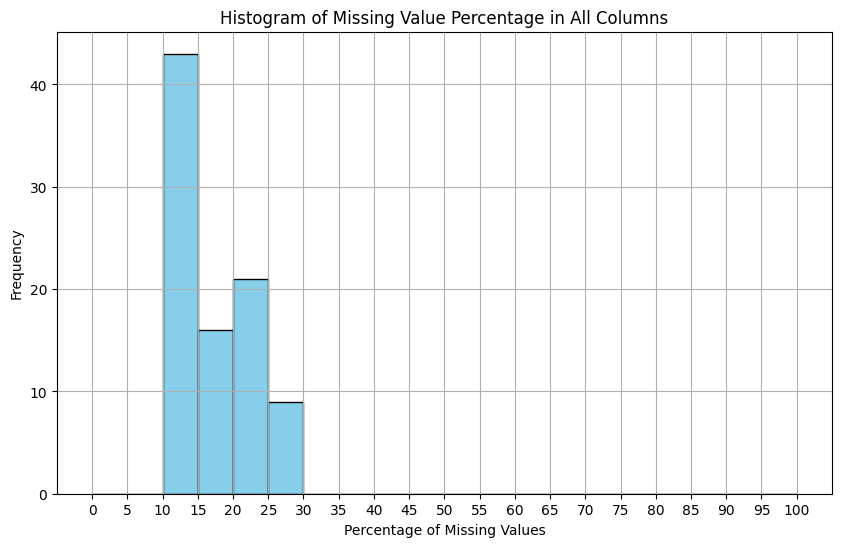

In [192]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df_70
# Calculate the percentage of missing values in each column
missing_percentage = (df_70.isnull().sum() / len(df_70)) * 100

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(missing_percentage, bins=range(0, 101, 5), color='skyblue', edgecolor='black')
plt.title('Histogram of Missing Value Percentage in All Columns')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Frequency')
plt.xticks(range(0, 101, 5))
plt.grid(True)
plt.show()


In [196]:
speed_data_2

,101.1.35,125.2.49,126.1.49,126.2.80,138.2.55,141.2.55,154.2.240,167.2.210,38.1.91,398.3.411,...,99.1.35,522.1.17,522.2.15,523.1.12,523.2.84,525.1.93,525.2.142,525.3.145,526.1.144,526.2.79
DateTimeStamp,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01 00:15:00,0.0,55.50,49.0,30.0,NaN,0.0,0.0,64.00,0.0,62.500000,...,66.6,44.000000,56.00,59.500000,NaN,0.0,0.0,82.00,0.00,0.00
2018-01-01 00:30:00,0.0,55.00,50.0,30.0,NaN,0.0,0.0,62.50,0.0,53.500000,...,68.2,28.333333,55.00,59.000000,NaN,0.0,0.0,81.50,0.00,0.00
2018-01-01 00:45:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,61.50,0.0,51.500000,...,67.6,11.333333,55.00,59.000000,NaN,0.0,0.0,84.50,0.00,0.00
2018-01-01 01:00:00,0.0,54.00,50.0,30.0,NaN,0.0,0.0,63.00,0.0,59.500000,...,67.8,26.500000,55.00,58.000000,NaN,0.0,0.0,84.50,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:30:00,NaN,61.00,NaN,NaN,NaN,0.0,0.0,63.00,NaN,61.333333,...,NaN,NaN,NaN,39.000000,NaN,NaN,NaN,80.50,70.50,73.00
2018-12-31 23:45:00,NaN,61.50,NaN,NaN,NaN,0.0,0.0,64.00,NaN,61.000000,...,NaN,NaN,NaN,37.666667,NaN,NaN,NaN,80.00,70.00,72.00
2018-11-04 01:15:00,NaN,57.00,54.0,NaN,NaN,0.0,0.0,63.25,0.0,41.666667,...,NaN,61.833333,60.50,64.833333,NaN,NaN,NaN,76.00,69.50,73.00


In [194]:
import pandas as pd

# Assuming your DataFrame is named df_70
# Initialize variables to store results
missing_rows_per_column = {}

# Iterate through each column
for column in df_70.columns:
    consecutive_missing = 0
    missing_rows = []

    # Iterate through each row
    for index, value in df_70[column].isna().items():
        if value:  # If value is missing
            consecutive_missing += 1
        else:  # If value is not missing
            if consecutive_missing != 0:  # Append consecutive missing rows if not zero
                missing_rows.append(consecutive_missing)
            consecutive_missing = 0

    # Store results for each column
    missing_rows_per_column[column] = missing_rows

# Calculate statistics
max_missing_rows_one_column = max(map(max, missing_rows_per_column.values()), default=0)
min_missing_rows_one_column = min(filter(lambda x: x != 0, map(min, missing_rows_per_column.values())), default=0)
mean_missing_rows_one_column = sum(map(sum, missing_rows_per_column.values())) / len(df_70)
mean_missing_rows_all_columns = sum(map(len, missing_rows_per_column.values())) / len(df_70.columns)

# Calculate mode
all_missing_rows = [item for sublist in missing_rows_per_column.values() for item in sublist]
mode_missing_rows = max(set(all_missing_rows), key=all_missing_rows.count)

# Print the results
print("Maximum missing rows in one column:", max_missing_rows_one_column)
print("Minimum missing rows in one column (excluding zero):", min_missing_rows_one_column)
print("Mean missing rows in one column:", mean_missing_rows_one_column)
print("Mode number of missing rows in one column:", mode_missing_rows)
print("Average number of missing rows in all columns:", mean_missing_rows_all_columns)


Maximum missing rows in one column: 6229
Minimum missing rows in one column (excluding zero): 1
Mean missing rows in one column: 15.817437214611871
Mode number of missing rows in one column: 1
Average number of missing rows in all columns: 4139.314606741573


In [195]:
import pandas as pd

# Assuming your DataFrame is named df_70
# Initialize variables to store results
missing_stretches_per_column = {}

# Iterate through each column
for column in df_70.columns:
    consecutive_missing = 0
    missing_stretches = []

    # Iterate through each row
    for index, value in df_70[column].isna().items():
        if value:  # If value is missing
            consecutive_missing += 1
        else:  # If value is not missing
            if consecutive_missing != 0:  # Append consecutive missing rows if not zero
                missing_stretches.append(consecutive_missing)
            consecutive_missing = 0

    # Store results for each column
    missing_stretches_per_column[column] = missing_stretches

# Calculate statistics
max_missing_stretch_one_column = max(map(max, missing_stretches_per_column.values()), default=0)
min_missing_stretch_one_column = min(filter(lambda x: x != 0, map(min, missing_stretches_per_column.values())), default=0)
mean_missing_stretch_one_column = sum(map(sum, missing_stretches_per_column.values())) / len(df_70)
mean_missing_stretch_all_columns = sum(map(len, missing_stretches_per_column.values())) / len(df_70.columns)

# Print the results
print("Maximum missing stretch in one column:", max_missing_stretch_one_column)
print("Minimum missing stretch in one column (excluding zero):", min_missing_stretch_one_column)
print("Mean missing stretch in one column:", mean_missing_stretch_one_column)
print("Average number of missing stretches in all columns:", mean_missing_stretch_all_columns)


Maximum missing stretch in one column: 6229
Minimum missing stretch in one column (excluding zero): 1
Mean missing stretch in one column: 15.817437214611871
Average number of missing stretches in all columns: 4139.314606741573


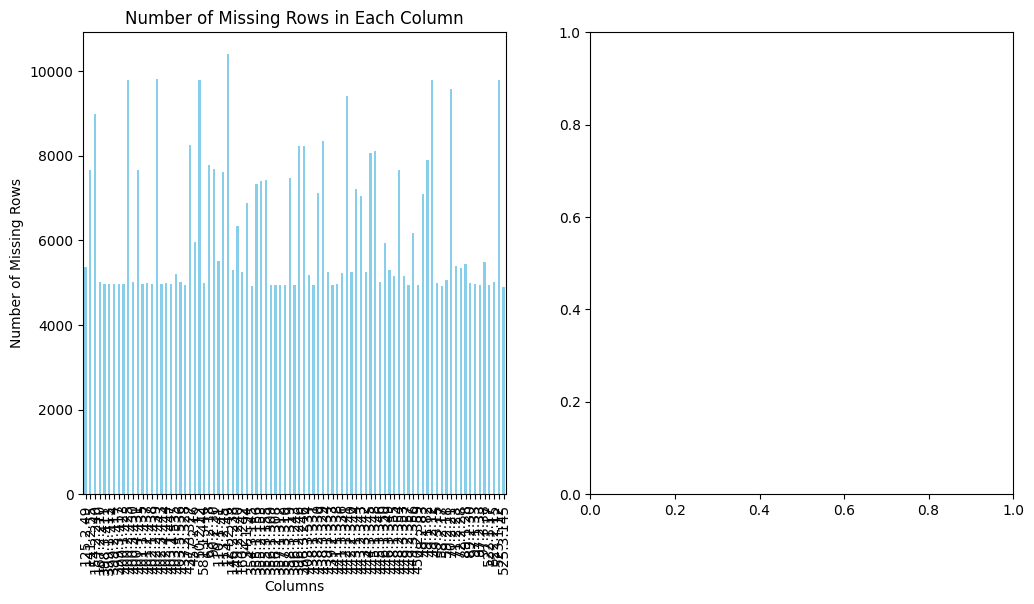

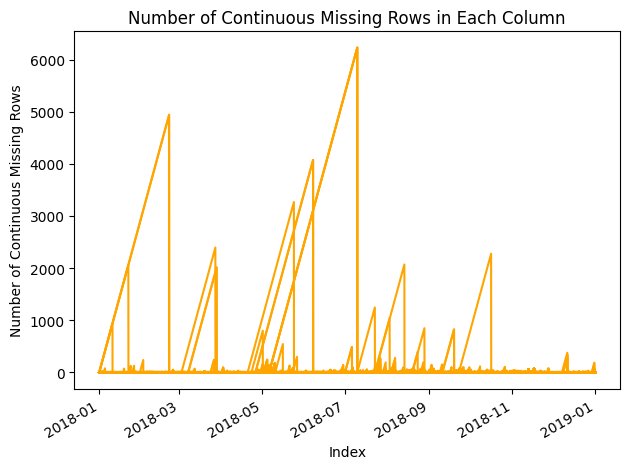

In [199]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_70 is your DataFrame, replace it with your actual DataFrame name
# Load your DataFrame or replace this line with your DataFrame loading code
# df_70 = pd.read_csv('your_file.csv')

# Calculate the number of missing rows in each column
missing_row_count = df_70.isnull().sum()

# Calculate the number of continuous missing rows in each column
continuous_missing_rows = df_70.apply(lambda x: x.isnull().astype(int).groupby(x.notnull().astype(int).cumsum()).cumsum())

# Plotting
plt.figure(figsize=(12, 6))

# Plot the number of missing rows
plt.subplot(1, 2, 1)
missing_row_count.plot(kind='bar', color='skyblue')
plt.title('Number of Missing Rows in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Rows')

# Plot the number of continuous missing rows
plt.subplot(1, 2, 2)
continuous_missing_rows.plot(legend=False, color='orange')
plt.title('Number of Continuous Missing Rows in Each Column')
plt.xlabel('Index')
plt.ylabel('Number of Continuous Missing Rows')

plt.tight_layout()
plt.show()


In [205]:
import pandas as pd

# Assuming df_70 is your DataFrame, replace it with your actual DataFrame name
# Load your DataFrame or replace this line with your DataFrame loading code
# df_70 = pd.read_csv('your_file.csv')

# Calculate the number of continuous missing rows in each column
continuous_missing_rows = df_70.apply(lambda x: x.isnull().astype(int).groupby(x.notnull().astype(int).cumsum()).cumsum())

# Get statistics for continuous missing rows
stats = []
for column_name in continuous_missing_rows.columns:
    column_data = continuous_missing_rows[column_name]
    max_length = column_data.max()
    min_length = column_data[column_data != 0].min() if (column_data != 0).any() else 0
    avg_length = column_data[column_data != 0].mean() if (column_data != 0).any() else 0
    total_missing = (column_data != 0).sum()
    stats.append((max_length, min_length, avg_length, total_missing))

# Create a DataFrame to store the statistics
stats_df = pd.DataFrame(stats, index=continuous_missing_rows.columns, columns=['Max', 'Min', 'Mean', 'Number of Continuous Missing Rows'])

# Calculate the median of each row and add it as a new column
stats_df['Median'] = stats_df.median(axis=1)

print("Statistics for Continuous Missing Rows in Each Column with Median:")
print(stats_df)


print("Statistics for Continuous Missing Rows in Each Column:")
print(stats_df)


Statistics for Continuous Missing Rows in Each Column:
            Max  Min         Mean  Number of Continuous Missing Rows
125.2.49    241    1    11.099963                               5382
141.2.55    133    1     4.773844                               7654
154.2.240   824    1    56.734497                               8998
167.2.210   133    1     4.323389                               5028
398.3.411   133    1     4.293999                               4966
...         ...  ...          ...                                ...
97.3.38     298    1    16.102443                               5486
522.1.17    167    1     5.425364                               4944
522.2.15    167    1     5.714371                               5017
523.1.12   6229    1  1986.518893                               9792
525.3.145   133    1     4.294106                               4903

[89 rows x 4 columns]


In [206]:
# Assuming stats_df is your DataFrame containing the statistics
# Calculate the average of the Max, Min, Mean, and Number of Continuous Missing Rows columns
average_max = stats_df['Max'].mean()
average_min = stats_df['Min'].mean()
average_mean = stats_df['Mean'].mean()
average_missing_rows = stats_df['Number of Continuous Missing Rows'].mean()

print("Average values for the statistics across all columns:")
print("Average Max:", average_max)
print("Average Min:", average_min)
print("Average Mean:", average_mean)
print("Average Number of Continuous Missing Rows:", average_missing_rows)


Average values for the statistics across all columns:
Average Max: 753.2696629213483
Average Min: 1.0
Average Mean: 155.72255235139824
Average Number of Continuous Missing Rows: 6227.449438202248


In [209]:
import pandas as pd

# Assuming df_70 is your DataFrame, replace it with your actual DataFrame name
# Load your DataFrame or replace this line with your DataFrame loading code
# df_70 = pd.read_csv('your_file.csv')

# Calculate the number of continuous missing rows in each column
continuous_missing_rows = df_70.apply(lambda x: x.isnull().astype(int).groupby(x.notnull().astype(int).cumsum()).cumsum())

# Get statistics for continuous missing rows
stats = []
for column_name in continuous_missing_rows.columns:
    column_data = continuous_missing_rows[column_name]
    max_length = column_data.max()
    min_length = column_data[column_data != 0].min() if (column_data != 0).any() else 0
    avg_length = column_data[column_data != 0].mean() if (column_data != 0).any() else 0
    median_length = column_data[column_data != 0].median() if (column_data != 0).any() else 0
    total_missing = (column_data != 0).sum()
    stats.append((max_length, min_length, avg_length, median_length, total_missing))

# Create a DataFrame to store the statistics
stats_df = pd.DataFrame(stats, index=continuous_missing_rows.columns, columns=['Max', 'Min', 'Mean', 'Median', 'Number of Continuous Missing Rows'])

print("Statistics for Continuous Missing Rows in Each Column with Median Continuous Missing Rows:")
print(stats_df)


Statistics for Continuous Missing Rows in Each Column with Median Continuous Missing Rows:
            Max  Min         Mean  Median  Number of Continuous Missing Rows
125.2.49    241    1    11.099963     1.0                               5382
141.2.55    133    1     4.773844     1.0                               7654
154.2.240   824    1    56.734497     3.0                               8998
167.2.210   133    1     4.323389     1.0                               5028
398.3.411   133    1     4.293999     1.0                               4966
...         ...  ...          ...     ...                                ...
97.3.38     298    1    16.102443     1.0                               5486
522.1.17    167    1     5.425364     1.0                               4944
522.2.15    167    1     5.714371     1.0                               5017
523.1.12   6229    1  1986.518893  1333.5                               9792
525.3.145   133    1     4.294106     1.0                     

In [220]:
import pandas as pd
import numpy as np

# Load the existing dataset from which parameters will be learned
existing_df = df_70

# Calculate the statistics for continuous missing rows in each column
continuous_missing_rows = existing_df.apply(lambda x: x.isnull().astype(int).groupby(x.notnull().astype(int).cumsum()).cumsum())
stats = []
for column_name in continuous_missing_rows.columns:
    column_data = continuous_missing_rows[column_name]
    max_length = column_data.max()
    min_length = column_data[column_data != 0].min() if (column_data != 0).any() else 0
    avg_length = column_data[column_data != 0].mean() if (column_data != 0).any() else 0
    median_length = column_data[column_data != 0].median() if (column_data != 0).any() else 0
    total_missing = (column_data != 0).sum()
    stats.append((max_length, min_length, avg_length, median_length, total_missing))

# Load the new dataset where missing values will be introduced
new_df = pd.read_csv('C:/Users/Tarek Zahid/Desktop/speedx26_train.csv')

# Introduce missing values based on the learned parameters
np.random.seed(42)  # for reproducibility
for idx, column_name in enumerate(new_df.columns):
    # Skip if the column index exceeds the number of columns in the existing DataFrame
    if idx >= len(stats):
        break
    max_length, min_length, _, median_length, _ = stats[idx]
    num_missing_rows = np.random.randint(min_length, max_length + 1, size=len(new_df))
    for i, num_missing in enumerate(num_missing_rows):
        if num_missing > 0:
            start = np.random.randint(0, len(new_df) - num_missing + 1)
            new_df.loc[start:start+num_missing, column_name] = np.nan

# Save the modified dataset with missing values to a new CSV file
new_df.to_csv('C:/Users/Tarek Zahid/Desktop/speedx26_train_with_missing_values.csv', index=False)
